In [1]:
import pandas as pd
import os
import glob

from tqdm.notebook import tqdm
import gc
tqdm.pandas()

import warnings 
warnings.filterwarnings('ignore')

from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

import umap
import matplotlib.pyplot as plt

2024-04-21 12:21:19.692687: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-21 12:21:19.692745: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-21 12:21:19.730086: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# /workdir/practical-mi-guide/chapter5/input/livedoor-news-data/textのtextファイルを読み込み、フォルダ名ごとにデータフレームを作成する

# ファイルの読み込み
def read_file(file_path):
    with open(file_path, 'r') as f:
        text = f.read()
    return text

# フォルダの読み込み
def read_folder(folder_path):
    files = glob.glob(folder_path + '/*.txt')
    texts = [read_file(file) for file in files]
    return texts

# フォルダの読み込み
def read_folders(folder_paths):
    texts = [read_folder(folder_path) for folder_path in folder_paths]
    return texts

# フォルダのパスを取得
folder_paths = glob.glob('../input/livedoor-news-data/text/*')

# フォルダごとにデータフレームを作成
dfs = []
for folder_path in tqdm(folder_paths):
    folder_name = os.path.basename(folder_path)
    texts = read_folder(folder_path)
    df = pd.DataFrame({'text': texts, 'label': folder_name})
    dfs.append(df)
    
df = pd.concat(dfs, ignore_index=True)

print(df['label'].value_counts())

  0%|          | 0/11 [00:00<?, ?it/s]

label
sports-watch      901
dokujo-tsushin    871
it-life-hack      871
movie-enter       871
smax              871
kaden-channel     865
peachy            843
topic-news        771
livedoor-homme    512
Name: count, dtype: int64


In [3]:
df

,text,label
0,http://news.livedoor.com/article/detail/477803...,dokujo-tsushin
1,http://news.livedoor.com/article/detail/477803...,dokujo-tsushin
2,http://news.livedoor.com/article/detail/478252...,dokujo-tsushin
3,http://news.livedoor.com/article/detail/478835...,dokujo-tsushin
4,http://news.livedoor.com/article/detail/478836...,dokujo-tsushin
...,...,...
7371,http://news.livedoor.com/article/detail/690319...,topic-news
7372,http://news.livedoor.com/article/detail/690715...,topic-news
7373,http://news.livedoor.com/article/detail/690942...,topic-news
7374,http://news.livedoor.com/article/detail/690945...,topic-news


In [4]:
df['text'][0]

'http://news.livedoor.com/article/detail/4778030/\n2010-05-22T14:30:00+0900\n友人代表のスピーチ、独女はどうこなしている？\n\u3000もうすぐジューン・ブライドと呼ばれる６月。独女の中には自分の式はまだなのに呼ばれてばかり……という「お祝い貧乏」状態の人も多いのではないだろうか？\u3000さらに出席回数を重ねていくと、こんなお願いごとをされることも少なくない。\n\n\u3000「お願いがあるんだけど……友人代表のスピーチ、やってくれないかな？」\n\n\u3000さてそんなとき、独女はどう対応したらいいか？\n\n\u3000最近だとインターネット等で検索すれば友人代表スピーチ用の例文サイトがたくさん出てくるので、それらを参考にすれば、無難なものは誰でも作成できる。しかし由利さん（33歳）はネットを参考にして作成したものの「これで本当にいいのか不安でした。一人暮らしなので聞かせて感想をいってくれる人もいないし、かといって他の友人にわざわざ聞かせるのもどうかと思うし……」ということで活用したのが、なんとインターネットの悩み相談サイトに。そこに作成したスピーチ文を掲載し「これで大丈夫か添削してください」とメッセージを送ったというのである。\n\n\u3000「一晩で3人位の人が添削してくれましたよ。ちなみに自分以外にもそういう人はたくさんいて、その相談サイトには同じように添削をお願いする投稿がいっぱいありました」（由利さん）。ためしに教えてもらったそのサイトをみてみると、確かに「結婚式のスピーチの添削お願いします」という投稿が1000件を超えるくらいあった。めでたい結婚式の影でこんなネットコミュニティがあったとは知らなかった。\n\n\u3000しかし「事前にお願いされるスピーチなら準備ができるしまだいいですよ。一番嫌なのは何といってもサプライズスピーチ！」と語るのは昨年だけで10万以上お祝いにかかったというお祝い貧乏独女の薫さん（35歳）\n\n\u3000「私は基本的に人前で話すのが苦手なんですよ。だからいきなり指名されるとしどろもどろになって何もいえなくなる。そうすると自己嫌悪に陥って終わった後でもまったく楽しめなくなりますね」\n\u3000\n\u3000サプライズスピーチのメ

In [5]:
# df['text']の文章からhttps://～を削除する
df['text'] = df['text'].str.replace('https?://[\w/:%#\$&\?\(\)~\.=\+\-]+', '', regex=True)
df

,text,label
0,\n2010-05-22T14:30:00+0900\n友人代表のスピーチ、独女はどうこなし...,dokujo-tsushin
1,\n2010-05-21T14:30:00+0900\nネットで断ち切れない元カレとの縁\n...,dokujo-tsushin
2,\n2010-05-23T11:00:00+0900\n相次ぐ芸能人の“すっぴん”披露 その...,dokujo-tsushin
3,\n2010-05-25T14:00:00+0900\nムダな抵抗！？ 加齢の現実\n ヒッ...,dokujo-tsushin
4,\n2010-05-26T14:00:00+0900\n税金を払うのは私たちなんですけど！\...,dokujo-tsushin
...,...,...
7371,\n2012-08-30T11:51:00+0900\n 爆笑問題・田中裕二も驚く「ひるおび...,topic-news
7372,\n2012-08-31T11:53:00+0900\n黒田勇樹のDV騒動 ネット掲示板では...,topic-news
7373,\n2012-09-01T08:00:00+0900\nサムスンのアンドロイド搭載カメラが韓...,topic-news
7374,\n2012-08-31T21:00:00+0900\n米紙も注目したゲーム「竹島争奪戦」\...,topic-news


In [6]:
# df['text']の文章から改行コードを削除する
df['text'] = df['text'].str.replace('\n', '', regex=True)
df

,text,label
0,2010-05-22T14:30:00+0900友人代表のスピーチ、独女はどうこなしている？...,dokujo-tsushin
1,2010-05-21T14:30:00+0900ネットで断ち切れない元カレとの縁 携帯電話が...,dokujo-tsushin
2,2010-05-23T11:00:00+0900相次ぐ芸能人の“すっぴん”披露 その時、独女...,dokujo-tsushin
3,2010-05-25T14:00:00+0900ムダな抵抗！？ 加齢の現実 ヒップの加齢によ...,dokujo-tsushin
4,2010-05-26T14:00:00+0900税金を払うのは私たちなんですけど！ 6月から...,dokujo-tsushin
...,...,...
7371,2012-08-30T11:51:00+0900 爆笑問題・田中裕二も驚く「ひるおび!」での...,topic-news
7372,2012-08-31T11:53:00+0900黒田勇樹のDV騒動 ネット掲示板では冷ややか...,topic-news
7373,2012-09-01T08:00:00+0900サムスンのアンドロイド搭載カメラが韓国で話題...,topic-news
7374,2012-08-31T21:00:00+0900米紙も注目したゲーム「竹島争奪戦」米紙「ウォ...,topic-news


In [7]:
# https://huggingface.co/tohoku-nlp/bert-base-japanese-charを使用して文章のベクトル化を行う

# モデルの読み込み
model = SentenceTransformer('tohoku-nlp/bert-base-japanese-char')

# ベクトル化
vectors = model.encode(df['text'].values, show_progress_bar=True)

Batches:   0%|          | 0/231 [00:00<?, ?it/s]

In [8]:
# vectorsをデータフレームに変換
vectors_df = pd.DataFrame(vectors)
vectors_df

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
0,-0.171062,-0.056970,0.159182,-0.118117,0.073091,0.356586,-0.540856,0.158613,0.177106,-0.092121,...,-0.123969,0.044025,0.179588,-0.081374,0.153885,0.078990,-0.012975,0.029733,0.035927,0.029595
1,-0.134912,-0.100715,0.034894,-0.061439,0.118125,0.426431,-0.522420,0.229785,0.145787,-0.069843,...,-0.025382,0.110752,0.068614,-0.091692,0.182168,-0.047445,-0.192972,0.054825,-0.025621,0.121442
2,-0.077748,-0.134157,0.102809,-0.125905,0.074059,0.317202,-0.502061,0.039856,0.244771,-0.110735,...,0.013996,-0.024118,0.128714,-0.127270,0.207661,0.070088,-0.130730,0.049806,-0.043714,-0.052584
3,-0.064372,0.101648,0.025766,-0.102906,0.021930,0.203954,-0.310583,0.080995,0.266226,0.007451,...,0.086113,0.059640,0.150323,-0.094285,0.102046,-0.032379,-0.155004,0.116054,-0.064743,0.009093
4,-0.181365,-0.152231,0.018383,-0.000626,0.139977,0.250249,-0.537099,0.096134,0.216587,-0.134338,...,0.000252,0.182963,0.088941,-0.108586,0.205164,-0.167694,-0.133136,0.068920,-0.017325,-0.015941
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7371,0.079293,-0.004238,-0.004904,-0.025829,-0.158258,0.264084,-0.422311,0.151820,0.276188,-0.150400,...,-0.086956,0.054038,0.247591,-0.101051,0.043439,-0.020127,-0.104542,0.075056,0.049609,0.051130
7372,-0.122757,-0.018318,0.104039,-0.086501,0.000085,0.183817,-0.572020,0.094551,0.277044,-0.141229,...,0.050212,0.074005,0.168486,-0.056227,0.204564,-0.068644,-0.042986,0.036360,0.034187,-0.076134
7373,-0.032580,-0.073849,0.039261,-0.071468,0.031841,0.274799,-0.575031,0.250323,0.242248,-0.040540,...,0.045717,0.154937,0.007764,-0.023672,0.218673,-0.094990,0.006566,0.173999,-0.028422,0.014559
7374,0.007444,-0.025397,0.237850,0.041529,-0.105446,0.212441,-0.466351,0.207561,0.289747,-0.062557,...,0.049488,0.014019,0.121100,-0.011532,0.272902,-0.075224,-0.021128,0.149354,0.005062,-0.017338


In [9]:
# dfとvectors_dfを結合
df = pd.concat([df, vectors_df], axis=1)
df

,text,label,0,1,2,3,4,5,6,7,...,758,759,760,761,762,763,764,765,766,767
0,2010-05-22T14:30:00+0900友人代表のスピーチ、独女はどうこなしている？...,dokujo-tsushin,-0.171062,-0.056970,0.159182,-0.118117,0.073091,0.356586,-0.540856,0.158613,...,-0.123969,0.044025,0.179588,-0.081374,0.153885,0.078990,-0.012975,0.029733,0.035927,0.029595
1,2010-05-21T14:30:00+0900ネットで断ち切れない元カレとの縁 携帯電話が...,dokujo-tsushin,-0.134912,-0.100715,0.034894,-0.061439,0.118125,0.426431,-0.522420,0.229785,...,-0.025382,0.110752,0.068614,-0.091692,0.182168,-0.047445,-0.192972,0.054825,-0.025621,0.121442
2,2010-05-23T11:00:00+0900相次ぐ芸能人の“すっぴん”披露 その時、独女...,dokujo-tsushin,-0.077748,-0.134157,0.102809,-0.125905,0.074059,0.317202,-0.502061,0.039856,...,0.013996,-0.024118,0.128714,-0.127270,0.207661,0.070088,-0.130730,0.049806,-0.043714,-0.052584
3,2010-05-25T14:00:00+0900ムダな抵抗！？ 加齢の現実 ヒップの加齢によ...,dokujo-tsushin,-0.064372,0.101648,0.025766,-0.102906,0.021930,0.203954,-0.310583,0.080995,...,0.086113,0.059640,0.150323,-0.094285,0.102046,-0.032379,-0.155004,0.116054,-0.064743,0.009093
4,2010-05-26T14:00:00+0900税金を払うのは私たちなんですけど！ 6月から...,dokujo-tsushin,-0.181365,-0.152231,0.018383,-0.000626,0.139977,0.250249,-0.537099,0.096134,...,0.000252,0.182963,0.088941,-0.108586,0.205164,-0.167694,-0.133136,0.068920,-0.017325,-0.015941
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7371,2012-08-30T11:51:00+0900 爆笑問題・田中裕二も驚く「ひるおび!」での...,topic-news,0.079293,-0.004238,-0.004904,-0.025829,-0.158258,0.264084,-0.422311,0.151820,...,-0.086956,0.054038,0.247591,-0.101051,0.043439,-0.020127,-0.104542,0.075056,0.049609,0.051130
7372,2012-08-31T11:53:00+0900黒田勇樹のDV騒動 ネット掲示板では冷ややか...,topic-news,-0.122757,-0.018318,0.104039,-0.086501,0.000085,0.183817,-0.572020,0.094551,...,0.050212,0.074005,0.168486,-0.056227,0.204564,-0.068644,-0.042986,0.036360,0.034187,-0.076134
7373,2012-09-01T08:00:00+0900サムスンのアンドロイド搭載カメラが韓国で話題...,topic-news,-0.032580,-0.073849,0.039261,-0.071468,0.031841,0.274799,-0.575031,0.250323,...,0.045717,0.154937,0.007764,-0.023672,0.218673,-0.094990,0.006566,0.173999,-0.028422,0.014559
7374,2012-08-31T21:00:00+0900米紙も注目したゲーム「竹島争奪戦」米紙「ウォ...,topic-news,0.007444,-0.025397,0.237850,0.041529,-0.105446,0.212441,-0.466351,0.207561,...,0.049488,0.014019,0.121100,-0.011532,0.272902,-0.075224,-0.021128,0.149354,0.005062,-0.017338


In [10]:
# dfのvector列をUMAPを使って次元削減

# UMAP
umap_model = umap.UMAP(n_components=2, random_state=42)
umap_result = umap_model.fit_transform(vectors)

# UMAPの結果をデータフレームに変換
umap_df = pd.DataFrame(umap_result, columns=['umap1', 'umap2'])

# dfとumap_dfを結合
df = pd.concat([df, umap_df], axis=1)
df

,text,label,0,1,2,3,4,5,6,7,...,760,761,762,763,764,765,766,767,umap1,umap2
0,2010-05-22T14:30:00+0900友人代表のスピーチ、独女はどうこなしている？...,dokujo-tsushin,-0.171062,-0.056970,0.159182,-0.118117,0.073091,0.356586,-0.540856,0.158613,...,0.179588,-0.081374,0.153885,0.078990,-0.012975,0.029733,0.035927,0.029595,4.947545,10.154021
1,2010-05-21T14:30:00+0900ネットで断ち切れない元カレとの縁 携帯電話が...,dokujo-tsushin,-0.134912,-0.100715,0.034894,-0.061439,0.118125,0.426431,-0.522420,0.229785,...,0.068614,-0.091692,0.182168,-0.047445,-0.192972,0.054825,-0.025621,0.121442,5.471178,10.749705
2,2010-05-23T11:00:00+0900相次ぐ芸能人の“すっぴん”披露 その時、独女...,dokujo-tsushin,-0.077748,-0.134157,0.102809,-0.125905,0.074059,0.317202,-0.502061,0.039856,...,0.128714,-0.127270,0.207661,0.070088,-0.130730,0.049806,-0.043714,-0.052584,5.184289,10.096598
3,2010-05-25T14:00:00+0900ムダな抵抗！？ 加齢の現実 ヒップの加齢によ...,dokujo-tsushin,-0.064372,0.101648,0.025766,-0.102906,0.021930,0.203954,-0.310583,0.080995,...,0.150323,-0.094285,0.102046,-0.032379,-0.155004,0.116054,-0.064743,0.009093,5.935825,8.248117
4,2010-05-26T14:00:00+0900税金を払うのは私たちなんですけど！ 6月から...,dokujo-tsushin,-0.181365,-0.152231,0.018383,-0.000626,0.139977,0.250249,-0.537099,0.096134,...,0.088941,-0.108586,0.205164,-0.167694,-0.133136,0.068920,-0.017325,-0.015941,6.126963,9.827102
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7371,2012-08-30T11:51:00+0900 爆笑問題・田中裕二も驚く「ひるおび!」での...,topic-news,0.079293,-0.004238,-0.004904,-0.025829,-0.158258,0.264084,-0.422311,0.151820,...,0.247591,-0.101051,0.043439,-0.020127,-0.104542,0.075056,0.049609,0.051130,11.038068,8.749392
7372,2012-08-31T11:53:00+0900黒田勇樹のDV騒動 ネット掲示板では冷ややか...,topic-news,-0.122757,-0.018318,0.104039,-0.086501,0.000085,0.183817,-0.572020,0.094551,...,0.168486,-0.056227,0.204564,-0.068644,-0.042986,0.036360,0.034187,-0.076134,11.239373,7.777164
7373,2012-09-01T08:00:00+0900サムスンのアンドロイド搭載カメラが韓国で話題...,topic-news,-0.032580,-0.073849,0.039261,-0.071468,0.031841,0.274799,-0.575031,0.250323,...,0.007764,-0.023672,0.218673,-0.094990,0.006566,0.173999,-0.028422,0.014559,8.283060,4.891992
7374,2012-08-31T21:00:00+0900米紙も注目したゲーム「竹島争奪戦」米紙「ウォ...,topic-news,0.007444,-0.025397,0.237850,0.041529,-0.105446,0.212441,-0.466351,0.207561,...,0.121100,-0.011532,0.272902,-0.075224,-0.021128,0.149354,0.005062,-0.017338,11.656716,6.893337


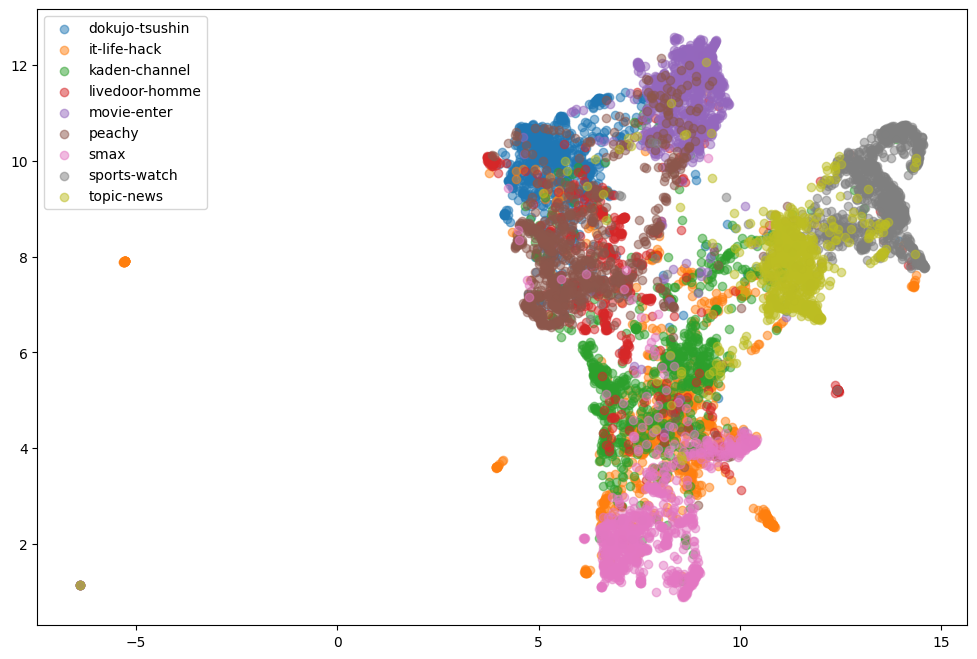

In [11]:
# umap1とumap2をプロット、labelごとに色分けして透過度を変える
plt.figure(figsize=(12, 8))
for label in df['label'].unique():
    plt.scatter(df[df['label'] == label]['umap1'], df[df['label'] == label]['umap2'], label=label, alpha=0.5)
plt.legend()
plt.show()